# GEDI Level 2B Vertical Plant Profiles

The GEDI Level 2B product provides vertical cover, plant area index (PAI) and plant area volume density (PAVD) profiles at a vertical resolution of 5 m. This notebook shows how to retrieve the directional gap probability (Pgap) profile from the Level 2B product using GEDIPy, compute these vertical profile metrics at the vertical resolution of the original Level 1B waveform, and then visualize them.

In [2]:
import numpy
import pandas

import matplotlib.pyplot as plt
import ipywidgets

from gedipy import h5io
from dask import delayed, compute, visualize
import numpy as np

## A function to recompute vertical profiles
We need datasets from the Level 2B file to compute the zenith angle of laser shot and also ancillary metrics including the RossG coefficent (canopy element projection function) and Omega coefficient (clumping factor)

In [3]:
def get_vertical_profiles(pgap_theta_z, height, local_beam_elevation, rossg, omega):
    cos_zenith = numpy.abs( numpy.sin(local_beam_elevation) )
    cover_z = cos_zenith * (1.0 - pgap_theta_z)
    pai_z = -(1.0 / (rossg * omega)) * numpy.log(pgap_theta_z) * cos_zenith
    pavd_z = -numpy.gradient(pai_z, height)       
    return cover_z, pai_z, pavd_z

## Open the H5 file
We select one of the power beams for this example

In [4]:
file_path_2B = "/home/stef/Testbed/00_data/GEDI/GEDI02_B_2019113083317_O02042_T04038_02_001_01.h5"
l2b_f = delayed(h5io.GEDIH5File)(file_path_2B)
l2b_f = compute(l2b_f)[0]
l2b_f

In [5]:
l2b_f.open()
beam = 'BEAM1011'
l2b_f.beams

['BEAM0000',
 'BEAM0001',
 'BEAM0010',
 'BEAM0011',
 'BEAM0101',
 'BEAM0110',
 'BEAM1000',
 'BEAM1011']

## Read all the profiles for one beam
This remaps the 1D pgap_theta_z array to a 2D M x N array, where M is the number Pgap profiles bins and N is the number of GEDI shots

In [6]:
from dask import delayed, compute, visualize

In [7]:
    def _expand(pgap):
            return np.expand_dims(pgap, axis=0)
    
    def read_pgap_theta_z_dask(l2b_f, beam, start=0, finish=None, minlength=None,
                          height=False, start_offset=0):
        """
        Remap the 1D pgap_theta_z array to a 2D M x N array, where M is
        the number Pgap profiles bins and N is the number of GEDI shots
        
        Parameters
        ----------
        beam: str
            Name of beam assessed, i.e. 'BEAM0001'
        start: int
            start of np.ndarray like slicing, Default=0
        finish: int/ None
            end of np.ndarray like slicing, Default=None
        minlength:
            TBD, Default=None
        height: bool
            TBD
        start_offset: str
            TBD
        
        Returns
        -------
        out_pgap_profile: numpy.ndarray
            TBD
        out_height:
            TBD
        """
        if not finish:
            finish = len(l2b_f.fid[beam+'/rx_sample_start_index'])

        start_indices = da.from_array(l2b_f.fid[beam+'/rx_sample_start_index'][start:finish]-1)
        counts = da.from_array(l2b_f.fid[beam+'/rx_sample_count'][start:finish])
        pgap_profile = da.from_array(l2b_f.fid[beam+'/pgap_theta_z'][start_indices[0].compute():(start_indices[-1].compute()+counts[-1].compute())])

        max_count = counts.max() + start_offset
        if minlength:
            max_count = max(minlength, max_count)
        out_shape = (max_count.compute(), len(counts))

        out_pgap_profile = da.ones(out_shape, dtype=pgap_profile.dtype)
        pgap = da.from_array(l2b_f.fid[beam+'/pgap_theta'][start:finish])
        x = da.map_blocks(_expand, pgap).compute()
        out_pgap_profile *= x
        
        start_indices -= start_indices.min()       
        
        if height:
            height_bin0 = l2b_f[beam+'/geolocation/height_bin0'][start:finish]
            height_lastbin = l2b_f[beam+'/geolocation/height_lastbin'][start:finish]
            v = (height_bin0 - height_lastbin) / (counts - 1)

            bin_dist = numpy.expand_dims(numpy.arange(max_count), axis=1)
            out_height = (numpy.expand_dims(height_bin0, axis=0) - 
                numpy.repeat(bin_dist,v.shape[0],axis=1) * v + 
                start_offset * v)

            return out_pgap_profile, out_height
        else:
            return out_pgap_profile

In [8]:
class Student(object):

    @staticmethod
    def is_full_name(x, y, out, inputt):
        for i in range(len(x)):
            for j in range(y[i]):
                out[j+i] = inputt[x[i]+j]

x = np.array([0,0,0,0])
y = np.array([1, 0, 0, 0])
out = np.array([[0, 0, 0, 0], [0,0,0,0]])
inputt = np.array([1,1,1,1,1, 1, 1, 1])
Student.is_full_name(x, y, out, inputt)

In [9]:
out

array([[1, 1, 1, 1],
       [0, 0, 0, 0]])

In [10]:
def waveform_1d_to_2d_test(start_indices, counts, data, out_data, start_offset=0):
    for i in range(len(start_indices)):
        for j in range(counts[i]):
            out_data[j+start_offset, i] = data[start_indices[i] + j]

In [11]:
start_indices.shape

NameError: name 'start_indices' is not defined

In [12]:
counts.shape

NameError: name 'counts' is not defined

In [1]:
test = out_pgap_profile.compute()
test

NameError: name 'out_pgap_profile' is not defined

In [65]:
pgap_profile.shape

(17859208,)

In [77]:
17859208%1002

562

## Step through one by one

In [53]:
# Params

finish=None
start = 0
minlength=None
height=True
start_offset=0

In [54]:
if not finish:
    finish = len(l2b_f.fid[beam+'/rx_sample_start_index'])
    print(finish)

343171


In [9]:
import dask.array as da

In [10]:
start_indices = da.from_array(l2b_f.fid[beam+'/rx_sample_start_index'][start:finish]-1, chunks=33487)
counts = da.from_array(l2b_f.fid[beam+'/rx_sample_count'][start:finish], chunks=33487)
pgap_profile = da.from_array(l2b_f.fid[beam+'/pgap_theta_z'][start_indices[0].compute():(start_indices[-1].compute()+counts[-1].compute())])

In [11]:
max_count = counts.max() + start_offset
if minlength:
    max_count = max(minlength, max_count)
out_shape = (max_count.compute(), len(counts))

In [12]:
out_shape

(1002, 343171)

In [13]:
out_pgap_profile = da.ones(out_shape, dtype=pgap_profile.dtype)
out_pgap_profile.shape

(1002, 343171)

In [14]:
out_pgap_profile

dask.array<ones, shape=(1002, 343171), dtype=float32, chunksize=(1002, 33487), chunktype=numpy.ndarray>

In [15]:
pgap = da.from_array(l2b_f.fid[beam+'/pgap_theta'][start:finish])

In [16]:
pgap.shape

(343171,)

In [17]:
def expand(pgap, axis=0):
    return np.expand_dims(pgap, axis=axis)

x = da.map_blocks(expand, pgap).compute()
out_pgap_profile *= x
start_indices -= start_indices.min()

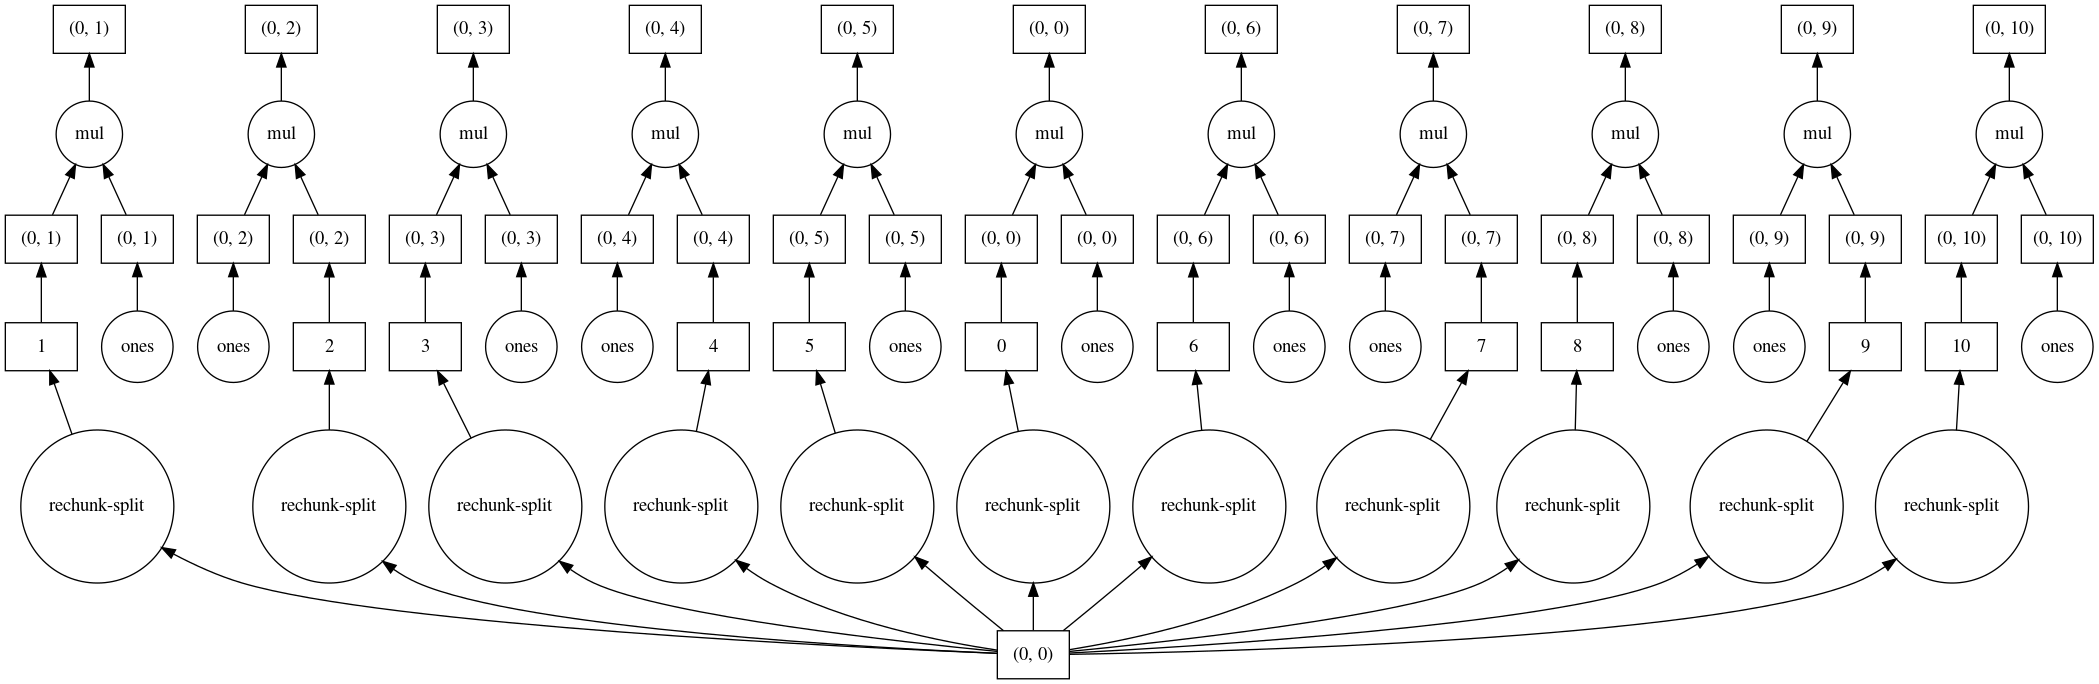

In [18]:
visualize(out_pgap_profile)
#start_indices, counts, pgap_profile, out_pgap_profile)

In [19]:
def waveform_1d_to_2d_test(start_indices, counts, data, out_data, start_offset=0):
    for i in range(len(start_indices)):
        for j in range(counts[i]):
            out_data[j+start_offset, i] = data[start_indices[i] + j]

In [36]:
data = pgap_profile
out_data = out_pgap_profile

In [46]:
temp = range(len(start_indices))
type(temp)

range

In [45]:
temp2 = range(10,1)
type(temp2)

range

In [37]:
for i in range(10):
    for j in range(counts[i]):
        out_data[j+start_offset, i] = data[start_indices[i] + j]

TypeError: 'Array' object cannot be interpreted as an integer

In [35]:
pgap_profile

dask.array<array, shape=(17859208,), dtype=float32, chunksize=(17859208,), chunktype=numpy.ndarray>

In [20]:
waveform_2d = delayed(waveform_1d_to_2d_test)(start_indices, counts, pgap_profile, out_pgap_profile, start_offset=start_offset)

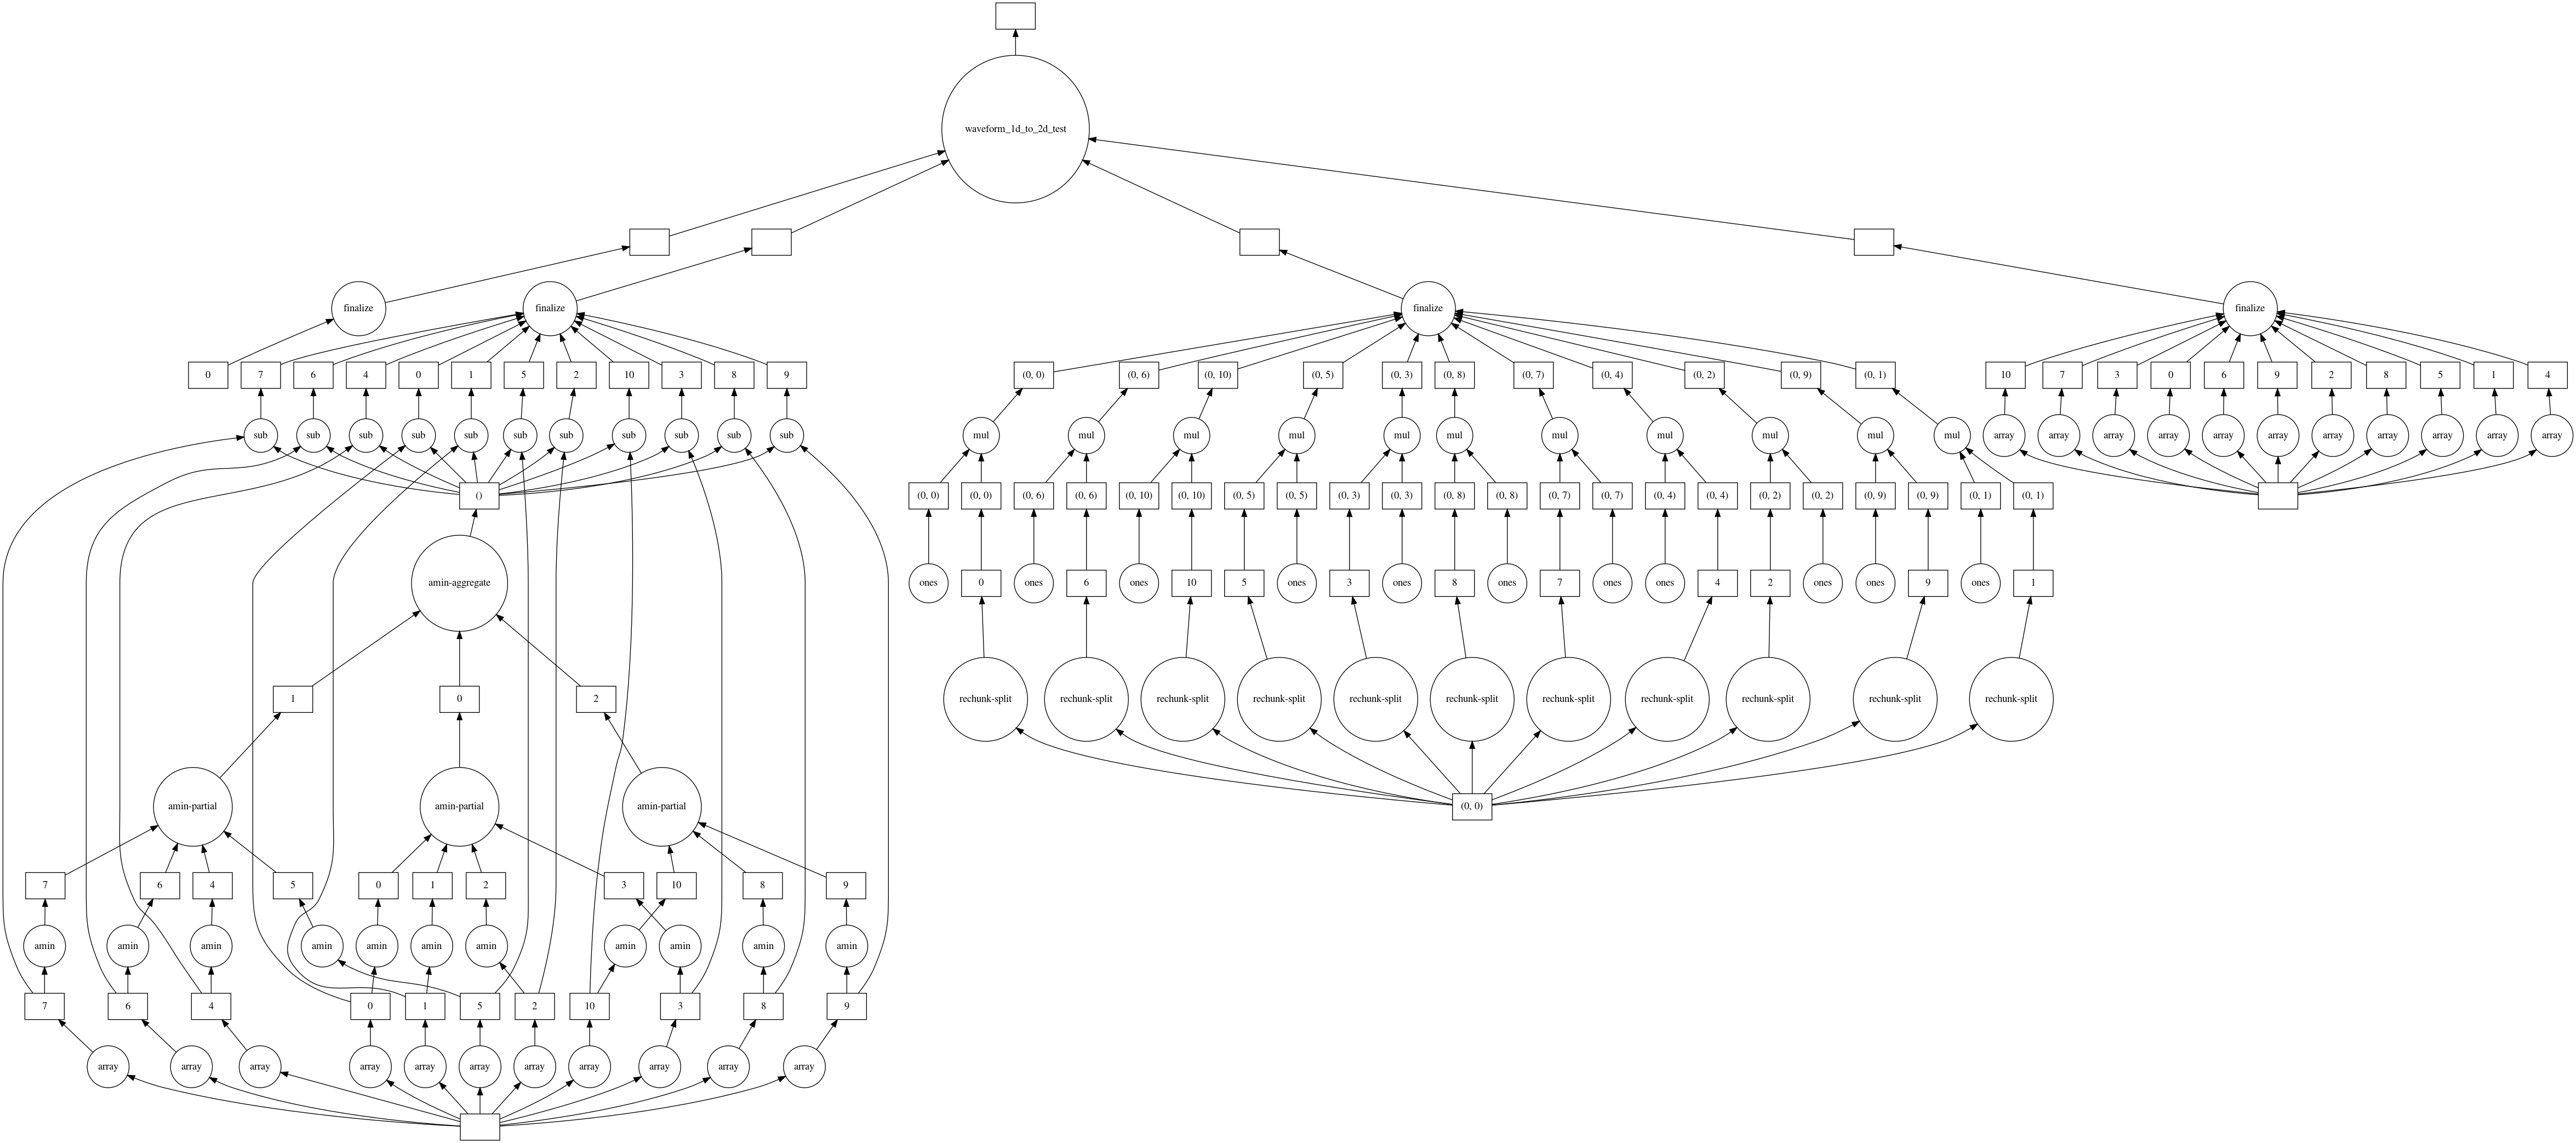

In [21]:
waveform_2d.visualize()

In [ ]:
waveform_2d.compute()

In [31]:
if height:
    height_bin0 = da.from_array(l2b_f.fid[beam+'/geolocation/height_bin0'][start:finish], chunks=(10000,))
    height_lastbin = da.from_array(l2b_f.fid[beam+'/geolocation/height_lastbin'][start:finish], chunks=(10000,))
    v = (height_bin0 - height_lastbin) / (counts - 1)
v

dask.array<truediv, shape=(343171,), dtype=float64, chunksize=(10000,), chunktype=numpy.ndarray>

In [32]:
da.arange(max_count).reshape([-1,1])

dask.array<reshape, shape=(1002, 1), dtype=int64, chunksize=(1002, 1), chunktype=numpy.ndarray>

In [33]:
bin_dis = da.arange(max_count).reshape([1,-1])

In [21]:
x = (da.map_blocks(expand, height_bin0, axis=0).compute() -
     numpy.repeat(expand, bin_dist,v.shape[0],axis=1) * v

np.expand_dims(height_bin0, axis=0).shape

/home/stef/miniconda3/envs/gedi/lib/python3.8/site-packages/dask/array/core.py:1348: FutureWarning: The `numpy.expand_dims` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


(1, 343171)

In [22]:
out_height = (numpy.expand_dims(height_bin0, axis=0) - 
                numpy.repeat(bin_dist,v.shape[0],axis=1) * v + 
                start_offset * v)

/home/stef/miniconda3/envs/gedi/lib/python3.8/site-packages/dask/array/core.py:1348: FutureWarning: The `numpy.expand_dims` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


NameError: name 'bin_dist' is not defined

In [ ]:
            bin_dist = numpy.expand_dims(numpy.arange(max_count), axis=1)
            out_height = (numpy.expand_dims(height_bin0, axis=0) - 
                numpy.repeat(bin_dist,v.shape[0],axis=1) * v + 
                start_offset * v)

In [ ]:
            out_height = (numpy.expand_dims(height_bin0, axis=0) - 
                numpy.repeat(bin_dist,v.shape[0],axis=1) * v + 
                start_offset * v)

In [27]:
# start_offset is used to buffer the start of the profile with pgap_theta_z = 1
start_offset = 5

result = l2b_f.read_pgap_theta_z(beam, height=True, start_offset=start_offset, dask=True)
pgap_theta_z, height = result[0], result[1]

visualize(pgap_theta_z, height)


TypeError: slice indices must be integers or None or have an __index__ method

## Read waveform and ancillary metrics

In [8]:
# Only read what we need - note that rh100 is in units of cm
dataset_l = ['shot_number', 'rh100', 'omega', 'rossg', 'l2b_quality_flag', 
                'pgap_theta_error', 'geolocation/local_beam_elevation']
l2b_data = l2b_f.read_shots(beam, dataset_list=dataset_l)

# Get the index of all quality shots
idx, = numpy.nonzero(l2b_data['l2b_quality_flag'])

# Use pandas to make it print nice
df = pandas.DataFrame(l2b_data)
df

,shot_number,rh100,omega,rossg,l2b_quality_flag,pgap_theta_error,local_beam_elevation
0,20421100100000001,0,1.0,0.5,0,-9999.000000,1.558602
1,20421100300000002,288,1.0,0.5,0,0.000114,1.558590
2,20421100500000003,288,1.0,0.5,0,0.000178,1.558589
3,20421100700000004,299,1.0,0.5,0,0.000056,1.558589
4,20421100900000005,292,1.0,0.5,0,0.000096,1.558589
...,...,...,...,...,...,...,...
343166,20421123300343167,322,1.0,0.5,0,0.000025,1.553505
343167,20421123500343168,306,1.0,0.5,0,0.000011,1.553504
343168,20421123700343169,318,1.0,0.5,0,0.000028,1.553504
343169,20421123900343170,336,1.0,0.5,0,0.000141,1.553504


In [15]:
import numpy as np

In [25]:
x = np.array([np.random.rand(10)])
x.max()

0.8822995549833164

In [42]:
import dask.array as da

In [43]:
x = da.from_array(l2b_data)
x

dask.array<array, shape=(343171,), dtype=[('shot_number', '<u8'), ('rh100', '<i2'), ('omega', '<f4'), ('rossg', '<f4'), ('l2b_quality_flag', 'u1'), ('pgap_theta_error', '<f4'), ('local_beam_elevation', '<f4')], chunksize=(343171,), chunktype=numpy.ndarray>

In [44]:
x.shape

(343171,)

In [ ]:
import dask.dataframe as dd

In [ ]:
ddf = dd.from_array(l2b_data)
ddf.tail()

## Plot example vertical plant profiles

In [ ]:
%matplotlib inline

def update(index=0):
    i = idx[index]
    
    err = l2b_data['pgap_theta_error'][i]
    rh100 = l2b_data['rh100'][i] / 100
        
    cover_z, pai_z, pavd_z = get_vertical_profiles(pgap_theta_z[:,i], height[:,i], 
        l2b_data['local_beam_elevation'][i], l2b_data['rossg'][i], l2b_data['omega'][i])
    cover_z0, pai_z0, pavd_z0 = get_vertical_profiles(pgap_theta_z[:,i]-err, height[:,i], 
        l2b_data['local_beam_elevation'][i], l2b_data['rossg'][i], l2b_data['omega'][i])
    cover_z1, pai_z1, pavd_z1 = get_vertical_profiles(pgap_theta_z[:,i]+err, height[:,i], 
        l2b_data['local_beam_elevation'][i], l2b_data['rossg'][i], l2b_data['omega'][i])
    
    first_canopy = numpy.argwhere(pgap_theta_z[:,i] < 1)[0][0]
    max_height = height[first_canopy,i]
    peak_canopy = numpy.argmax(pavd_z)
    peak_height = height[peak_canopy,i]
    
    fig,axs = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
    
    axs[0].fill_betweenx(height[:,i], pgap_theta_z[:,i]-err, pgap_theta_z[:,i]+err, 
                         facecolor='lightgrey')
    axs[0].plot(pgap_theta_z[:,i], height[:,i], color='black')
    axs[0].axhline(y=rh100, color='blue', linestyle='dashed', label='RH100')
    axs[0].axhline(y=max_height, color='darkgreen', linestyle='dashed', label='Canopy')
    axs[0].axhline(y=0, color='brown', linestyle='dashed', label='Ground')
    axs[0].legend(loc='upper right')
    
    axs[1].fill_betweenx(height[:,i], cover_z0, cover_z1, facecolor='lightgrey')
    axs[1].plot(cover_z, height[:,i], color='black')    
    axs[1].axhline(y=rh100, color='blue', linestyle='dashed', label='RH100')
    axs[1].axhline(y=max_height, color='darkgreen', linestyle='dashed', label='Canopy')
    axs[1].axhline(y=0, color='brown', linestyle='dashed', label='Ground')
    axs[1].legend(loc='upper right')
    
    axs[2].fill_betweenx(height[:,i], pai_z0, pai_z1, facecolor='lightgrey')
    axs[2].plot(pai_z, height[:,i], color='black')
    axs[2].axhline(y=rh100, color='blue', linestyle='dashed', label='RH100')
    axs[2].axhline(y=max_height, color='darkgreen', linestyle='dashed', label='Canopy')
    axs[2].axhline(y=0, color='brown', linestyle='dashed', label='Ground')
    axs[2].legend(loc='upper right')
    
    axs[3].fill_betweenx(height[:,i], pavd_z0, pavd_z1, facecolor='lightgrey')
    axs[3].plot(pavd_z, height[:,i], color='black')
    axs[3].axhline(y=rh100, color='blue', linestyle='dashed', label='RH100')
    axs[3].axhline(y=max_height, color='darkgreen', linestyle='dashed', label='Canopy')
    axs[3].axhline(y=0, color='brown', linestyle='dashed', label='Ground')
    axs[3].legend(loc='upper right')

    axs[0].set(xlim=(0, 1), ylim=(-2.5, height[first_canopy,i]+7.5), 
               title=r'$P_{gap} (\theta, z=0):\/$' + \
                     '{:.2f}'.format(pgap_theta_z[-1,i]),
               xlabel=r'$P_{gap} (\theta,z)$', ylabel='Height (m)')
    axs[1].set(xlim=(0, 1), xlabel='Canopy Cover Fraction (z)',
               title='CCF (z=0): {:.2f}'.format(cover_z[-1]))
    axs[2].set(xlim=(0, max(1,pai_z0[-1])), xlabel=r'$PAI (z)\/[m^{2} m^{-2}]$',
               title='PAI (z=0): {:.2f}'.format(pai_z[-1]))
    axs[3].set(xlim=(0, max(0.1,max(pavd_z0))), xlabel=r'$PAVD (z)\/[m^{2} m^{-3}]$',
               title=r'$H\/(z=max,top):\/$' + \
                     '{:.2f},{:.2f}'.format(peak_height,max_height))
    
    fig.suptitle('Vertical Plant Profiles (shot number: {:018d})'.format(l2b_data['shot_number'][i]))   
    fig.canvas.draw()
    
update(index=10542)

## Generate an interactive plot

In [ ]:
nrecords = numpy.count_nonzero(l2b_data['l2b_quality_flag'])
ipywidgets.interact(update, index=ipywidgets.IntSlider(min=0, max=nrecords-1, step=1, 
                                                       value=10542, continuous_update=False))